In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install keras
!pip install rasterio

     |████████████████████████████████| 19.3 MB 7.3 MB/s 


In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras.callbacks import ModelCheckpoint, Callback
import PIL
import warnings
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import rasterio
import glob
import sklearn
import tensorflow as tf
import keras

In [ ]:
from keras import backend as K
def wcceloss(y_true, y_pred):

    weights = np.array([0.5,2.5])
    weights = K.constant(weights)
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = y_true * K.log(y_pred) * weights
    loss = 1-K.sum(loss,axis= -1)
    #print(loss.shape)

    return loss

color_dict = {0: (0),
              1: (255),
              }

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    arr = np.zeros( shape, dtype=np.float32 )
    for i, cls in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,1) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

def onehot_to_rgb(onehot, color_dict):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return output

def adjustData(img1, img2, mask):
  onehot=rgb_to_onehot(mask[0],color_dict)
  onehot=np.reshape(onehot,((1,)+onehot.shape))
  img1 = img1/255
  img2 = img2/255
  #print(img1.shape,img2.shape,onehot.shape)
  return(img1, img2, onehot)
  


def TrainGenerator(aug_dict, train_path, image1_folder, image2_folder, mask_folder, batch_size, save_to_dir, seed = 1, 
                   image1_save_prefix = "image1", image2_save_prefix = "image2", mask_save_prefix = "mask"):
  image1_datagen = ImageDataGenerator(**aug_dict)
  image2_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  #print(os.getcwd())
  
  image1_generator = image1_datagen.flow_from_directory(
       directory = '/content/drive/MyDrive/Levir-CD/train/A',
       target_size = (512, 512),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image1_save_prefix,
       shuffle = True,
       seed = seed
  )
  image2_generator = image2_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/train/B',
      target_size = (512, 512),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image2_save_prefix,
       shuffle = True,
       seed = seed
  )
  mask_generator = mask_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/train/label',
      target_size = (512, 512),
       color_mode = 'grayscale',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = mask_save_prefix,
       shuffle = True,
       seed = seed
  )
  train_generator = zip(image1_generator, image2_generator, mask_generator)
  for (img1, img2, mask) in train_generator:
        img1, img2, mask = adjustData(img1, img2, mask)
        yield [img1, img2], mask

def ValGenerator(aug_dict, train_path, image1_folder, image2_folder, mask_folder, batch_size, save_to_dir, seed = 1, 
                   image1_save_prefix = "image1", image2_save_prefix = "image2", mask_save_prefix = "mask"):
  image1_datagen = ImageDataGenerator(**aug_dict)
  image2_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  #print(os.getcwd())
  
  image1_generator = image1_datagen.flow_from_directory(
       directory = '/content/drive/MyDrive/Levir-CD/val/A',
       target_size = (512, 512),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image1_save_prefix,
       shuffle = True,
       seed = seed
  )
  image2_generator = image2_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/val/B',
      target_size = (512, 512),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image2_save_prefix,
       shuffle = True,
       seed = seed
  )
  mask_generator = mask_datagen.flow_from_directory(
      directory = '/content/drive/MyDrive/Levir-CD/val/label',
      target_size = (512, 512),
       color_mode = 'grayscale',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = mask_save_prefix,
       shuffle = True,
       seed = seed
  )
  train_generator = zip(image1_generator, image2_generator, mask_generator)
  for (img1, img2, mask) in train_generator:
        img1, img2, mask = adjustData(img1, img2, mask)
        yield [img1, img2], mask
  
  

Finding Difficulty in creating model(don't know how to concatenate the output of base model) and also how to send the input images as pair wise to the model (tired to send the inputs as pair wise but got some broadcast error)

In [ ]:
from keras.layers import *


def Siamese(input_shape = (512,512,3)):
    input_1=Input(input_shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(input_1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv1)
    conv3 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv2)
    conv4 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv3)
    conv5 = Conv2D(16, 1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'random_normal')(conv4)
    #conv5 = Dropout(0.2)(conv5)

    input_2=Input(input_shape)
    conv_1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(input_2)
    conv_2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv_1)
    conv_3 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv_2)
    conv_4 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'random_normal')(conv_3)
    conv_5 = Conv2D(16, 1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'random_normal')(conv_4)
    #conv_5 = Dropout(0.2)(conv_5)
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    out  = L1_layer([conv5, conv_5])
    out = Dropout(0.25)(out)
    out = Dense(2,activation='softmax')(out)
    model = Model(inputs=[input_1,input_2],outputs= out)
    return model
model = Siamese()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 512, 512, 64) 1792        input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
path_of_training = '/content/drive/MyDrive/Levir-CD/train'
path_of_val = '/content/drive/MyDrive/Levir-CD/val'
data_gen_args = dict()
Train = TrainGenerator(aug_dict=data_gen_args, train_path=path_of_training, image1_folder ='A', image2_folder='B', mask_folder='label', batch_size=1, save_to_dir= None)
Val = ValGenerator(aug_dict=data_gen_args, train_path=path_of_val, image1_folder ='A', image2_folder='B', mask_folder='label', batch_size=1, save_to_dir= None) 

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

model.compile(optimizer = Adam(learning_rate = 0.0001), loss="binary_crossentropy" , metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(Train,validation_data = Val,validation_steps=128,steps_per_epoch=512,epochs=30,callbacks=[es,mc])
model.save("/content/")

Found 445 images belonging to 1 classes.
Found 445 images belonging to 1 classes.
Found 445 images belonging to 1 classes.
Epoch 1/30
512/512 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.9216Found 64 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
512/512 [==============================] - 142s 240ms/step - loss: 0.5293 - accuracy: 0.9216 - val_loss: 0.3653 - val_accuracy: 0.9580

Epoch 00001: val_accuracy improved from -inf to 0.95803, saving model to best_model.h5
Epoch 2/30
512/512 [==============================] - 123s 240ms/step - loss: 0.3639 - accuracy: 0.9521 - val_loss: 0.2728 - val_accuracy: 0.9580

Epoch 00002: val_accuracy did not improve from 0.95803
Epoch 3/30
512/512 [==============================] - 122s 238ms/step - loss: 0.2908 - accuracy: 0.9536 - val_loss: 0.2297 - val_accuracy: 0.9578

Epoch 00003: val_accuracy did not improve from 0.95803
Epoch 4/30
512/512 [===============

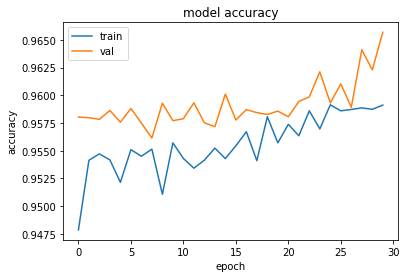

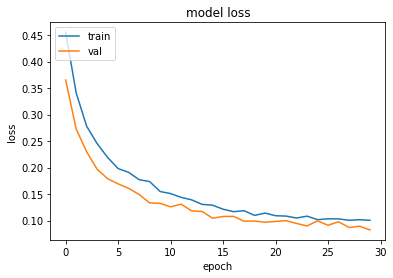

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model = load_model('/content/best_model.h5')
model.load_weights('/content/best_model.h5')
t = next(Val)
x_val = t[0]
y_val = t[1]
model.evaluate(x_val,y_val, verbose=1)

1/1 [==============================] - 1s 689ms/step - loss: 0.1219 - accuracy: 0.9448


[0.1219320297241211, 0.9448013305664062]

In [ ]:
def predGenerator(aug_dict, train_path, image1_folder, image2_folder, mask_folder, batch_size, save_to_dir, seed = 1, 
                   image1_save_prefix = "image1", image2_save_prefix = "image2", mask_save_prefix = "mask"):
    image1_datagen = ImageDataGenerator(**aug_dict)
    image2_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image1_generator = image1_datagen.flow_from_directory(
        directory = '/content/drive/MyDrive/Levir-CD/pred/A',
        target_size = (512,512),
        color_mode = 'rgb',
        class_mode = None,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = image1_save_prefix,
        shuffle = True,
        seed = seed
    )
    image2_generator = image2_datagen.flow_from_directory(
        directory = '/content/drive/MyDrive/Levir-CD/pred/B',
        target_size = (512,512),
        color_mode = 'rgb',
        class_mode = None,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = image2_save_prefix,
        shuffle = True,
        seed = seed
    )
    mask_generator = mask_datagen.flow_from_directory(
        directory = '/content/drive/MyDrive/Levir-CD/pred/label',
        target_size = (512,512),
        color_mode = 'grayscale',
        class_mode = None,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = mask_save_prefix,
        shuffle = True,
        seed = seed
    )
    train_generator = zip(image1_generator, image2_generator, mask_generator)
    for (img1, img2, mask) in train_generator:
          img1, img2, mask = adjustData(img1, img2, mask)
          yield [img1, img2], mask


In [ ]:
path_of_training = '/content/drive/MyDrive/Levir-CD/pred'
data_gen_args = dict()
pred= predGenerator(aug_dict=data_gen_args, train_path=path_of_training, image1_folder ='A', image2_folder='B', mask_folder='label', batch_size=1, save_to_dir= None)
t = next(pred)
X_train = t[0]
Y_train = t[1]
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(x_val, verbose=1)

Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 95ms/step


In [ ]:
from PIL import Image
_,h, w, c = preds_train.shape
preds_train = np.reshape(preds_train, (h, w, c))

img = preds_train
h, w, c = img.shape
color_dict = {0: (0),
              1: (255),
              }
# Generate one hot encoded array from predicted output.
for i in range(h):
    for j in range(w):
        # Select the index of max value among the 9 classes.
        argmax_index = np.argmax(img[i, j])
        onehot_arr = np.zeros((2))
        onehot_arr[argmax_index] = 1
        img[i, j, :] = onehot_arr

# Convert OneHotEncoded array to RGB.
def onehot_to_rgb(onehot, color_dict):
    print(onehot.shape)
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros(onehot.shape[:2]+(3,) )
    print(output.shape)
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)
  
y_pred_img = onehot_to_rgb(img,color_dict)

# Get the dimensions of the original image
h, w = 1024,1024

# Generate image and save it.
y_pred_img = y_pred_img[:h, :w, :]
imx = Image.fromarray(y_pred_img)
# Set file path appropriately
imx.save(
    "/content/"+str(1) + ".jpg")
print("Saved...")

(512, 512, 2)
(512, 512, 3)
Saved...


In [ ]:
preds_train_t = (preds_train >0.5).astype(np.uint8)
preds_val_t = (preds_val >0.5).astype(np.uint8)
print(preds_train_t.shape)

(1, 256, 256, 2)


In [ ]:
color_dict = {0: 0,1: 255,}
def onehot_to_rgb(onehot, color_dict):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:3]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return output
a = onehot_to_rgb(preds_train_t,color_dict)